https://discourse.pymc.io/t/sampling-uniformly-in-a-triangular-support/765/

In [1]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import theano
import seaborn as sns
import pystan

%pylab inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


In [2]:
with pm.Model() as m:
    x = pm.Uniform('x', 0., 1., shape=2)
    pm.Potential('ordered', tt.switch(x[1]-x[0] < 0, -np.inf, 0))
    tr = pm.sample(init='adapt_diag')

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_interval__]
INFO:pymc3:NUTS: [x_interval__]
100%|██████████| 1000/1000 [00:01<00:00, 716.61it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '18765' (I am process '18766')
INFO:theano.gof.compilelock:Waiting for existing lock by process '18765' (I am process '18766')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO:theano.gof.compilelock:To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '18765' (I am process '18767'

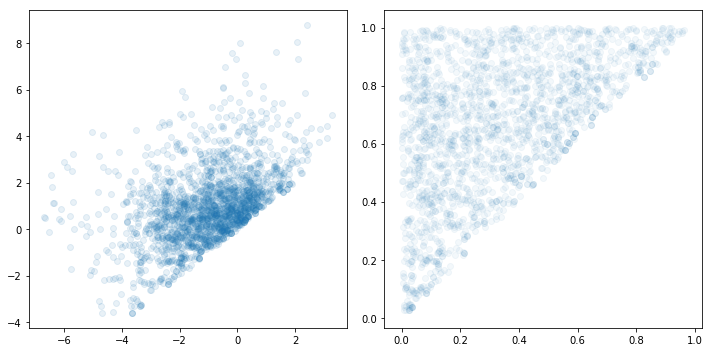

In [3]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(tr['x_interval__'][:, 0], tr['x_interval__'][:, 1], alpha=.1)
ax[1].scatter(tr['x'][:, 0], tr['x'][:, 1], alpha=.05)
plt.tight_layout();

In [4]:
def phi(x):
    #'Cumulative distribution function for the standard normal distribution'
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))

def normcdf1(thetap1, thetap2):
    angle = 45*np.pi/180
    return phi((np.cos(angle) * thetap1) - (np.sin(angle) * tt.abs_(thetap2)))

def normcdf2(thetap1, thetap2):
    angle = 45*np.pi/180
    return phi((np.sin(angle) * thetap1) + (np.cos(angle) * tt.abs_(thetap2)))

with pm.Model() as m1:
    thetap = pm.MvNormal('thetap', mu=0., cov=np.eye(2), shape=2)
    
    x1 = pm.Deterministic('x1', normcdf1(thetap[0], thetap[1]))
    x2 = pm.Deterministic('x2', normcdf2(thetap[0], thetap[1]))

    tr1 = pm.sample()

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetap]
INFO:pymc3:NUTS: [thetap]
100%|██████████| 1000/1000 [00:00<00:00, 1005.56it/s]


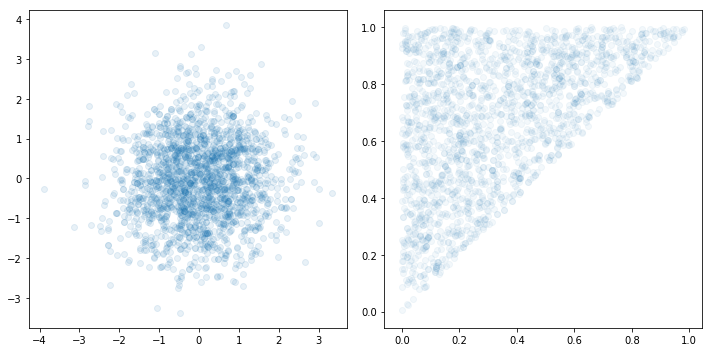

In [5]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(tr1['thetap'][:, 0], tr1['thetap'][:, 1], alpha=.1)
ax[1].scatter(tr1['x1'], tr1['x2'], alpha=.05)
plt.tight_layout();

In [6]:
datadict = {}
datadict['N'] = 2
stan_m = """
    data {
        int<lower=1> N;
    }
    parameters {
        ordered[N] x;
    }
    model {
        x ~ uniform(0, 1);
        // target += uniform_lpdf(x | 0, 1);
    }
    """

tr_stan = pystan.stan(model_code=stan_m, data=datadict,
                      iter=5000, warmup=1000, 
                      chains=4, n_jobs=4, verbose=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a354c77b7a6aa37371be175bb3cd19cd NOW.


cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
In file included from /home/laoj/.local/lib/python3.5/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:0,
                 from /home/laoj/.local/lib/python3.5/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /home/laoj/.local/lib/python3.5/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/tmp928hujk8/stanfit4anon_model_a354c77b7a6aa37371be175bb3cd19cd_3997924503832657866.cpp:599:
/home/laoj/.local/lib/python3.5/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^
In file included from /usr/local/lib/python3.5/dist-packages/pystan/stan/lib/stan_math/lib/boost_1.64.0/boost/multi_array/base.hpp:28:0,
                 fro

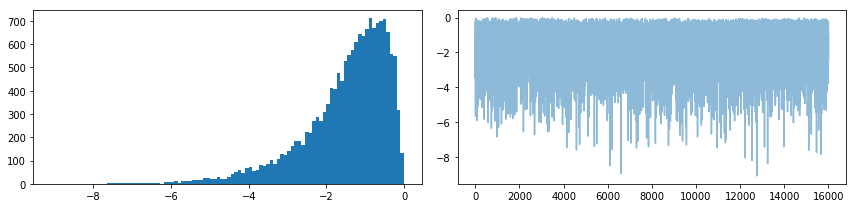

In [7]:
tr_x = tr_stan.extract()['x']
lnp = tr_stan.extract()['lp__']

_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(lnp, 100)
ax[1].plot(lnp, alpha=.5);
plt.tight_layout();

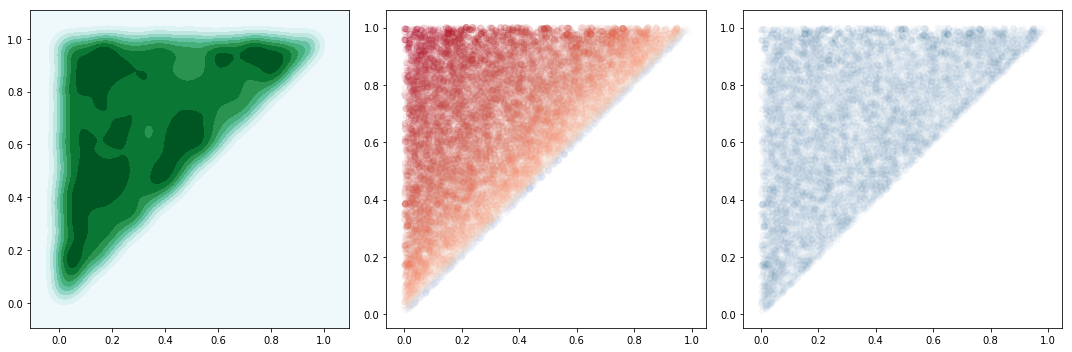

In [8]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(tr_x[:, 0], tr_x[:, 1], shade=True, ax=ax[0])
ax[1].scatter(tr_x[:, 0], tr_x[:, 1], c=lnp, cmap=plt.cm.coolwarm,
           alpha=.05)
ax[2].scatter(tr_x[:, 0], tr_x[:, 1], alpha=.01)
plt.tight_layout();

In [9]:
x = np.random.rand(1, 5).squeeze()
x

array([0.80383998, 0.91537551, 0.04386038, 0.68794726, 0.26985213])

In [10]:
def backward1(x):
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        if i>0:
            y[i] = y[i-1] + np.exp(x[i])
    return y

y = backward1(x)
y

array([0.80383998, 3.30155296, 4.34638943, 6.33601658, 7.64578733])

In [11]:
def backward2(x):
    y = np.zeros_like(x)
    y[0] = x[0]
    y[1:] = np.exp(x[1:])
    return np.cumsum(y)

y = backward2(x)
y

array([0.80383998, 3.30155296, 4.34638943, 6.33601658, 7.64578733])

In [12]:
def forward2(y):
    x = np.zeros_like(y)
    x[0] = y[0]
    x[1:] = np.log(y[1:] - y[:-1])
    return x

x2 = forward2(y)
x2

array([0.80383998, 0.91537551, 0.04386038, 0.68794726, 0.26985213])

In [13]:
class Ordered(pm.distributions.transforms.Transform):
    name = "ordered"

    def backward(self, y):
        out = tt.zeros(y.shape)
        out = tt.inc_subtensor(out[0], y[0])
        out = tt.inc_subtensor(out[1:], tt.exp(y[1:]))
        return tt.cumsum(out)

    def forward(self, x):
        out = tt.zeros(x.shape)
        out = tt.inc_subtensor(out[0], x[0])
        out = tt.inc_subtensor(out[1:], tt.log(x[1:] - x[:-1]))
        return out

    def forward_val(self, x, point=None):
        y = np.zeros_like(x)
        y[0] = x[0]
        y[1:] = np.log(x[1:] - x[:-1])
        return y

    def jacobian_det(self, y):
        return tt.sum(y[1:])
    
class Chained(pm.distributions.transforms.Transform):
    def __init__(self, transform_list):
        self.transform_list = transform_list
        self.name = '_'.join([transf.name for transf in self.transform_list])

    def forward(self, x):
        y = x
        for transf in self.transform_list:
            y = transf.forward(y)
        return y

    def forward_val(self, x, point=None):
        y = x
        for transf in self.transform_list:
            y = transf.forward_val(y)
        return y

    def backward(self, y):
        x = y
        for transf in reversed(self.transform_list):
            x = transf.backward(x)
        return x

    def jacobian_det(self, y):
        y_ = y
        det = 0.
        for transf in reversed(self.transform_list):
            det += transf.jacobian_det(y_)
            y_ = transf.backward(y_)
        return det

In [14]:
upper, lower = 0., 1.

Order = Ordered()
Interval = pm.distributions.transforms.Interval(upper, lower)
with pm.Model() as m2:
    chain_tran = Chained([Interval, Order])
    x = pm.Uniform('x', 0., 1., shape=2,
                   transform=chain_tran,
                   testval=[0.1, 0.9])
    pm.Deterministic('jacobian', chain_tran.jacobian_det(chain_tran.forward(x)))
    
    tr2 = pm.sample(5000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_interval_ordered__]
INFO:pymc3:NUTS: [x_interval_ordered__]
100%|██████████| 5500/5500 [00:04<00:00, 1305.68it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


In [15]:
varnames = tr2.varnames
varnames

['x_interval_ordered__', 'x', 'jacobian']

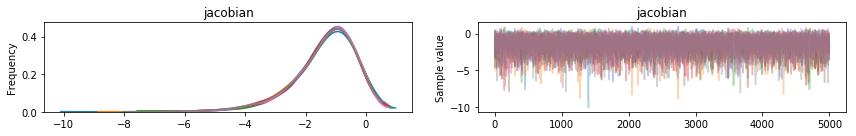

In [16]:
pm.traceplot(tr2, varnames=['jacobian']);

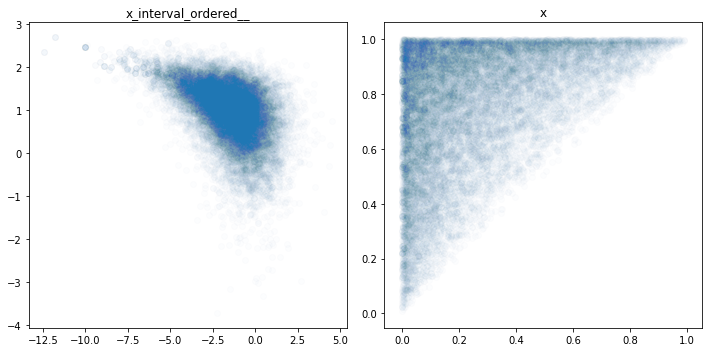

In [17]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
for ivar, varname in enumerate(varnames[:2]):
    ax[ivar].scatter(tr2[varname][:, 0], tr2[varname][:, 1], alpha=.01)
    ax[ivar].set_title(varname)
plt.tight_layout();

In [18]:
with pm.Model() as mtest:
    x = pm.Flat('x_interval_ordered__', shape=2, testval=[2., 1.])
    
    x1 = Order.backward(x)
    x2 = pm.Deterministic('x', Interval.backward(x1))
    
    pm.Potential('p1', Order.jacobian_det(x))
    pm.Potential('logp', pm.Uniform.dist(upper, lower).logp(x2))
    pm.Potential('p2', Interval.jacobian_det(x1))
    
    pm.Deterministic('jacobian', Order.jacobian_det(x) + Interval.jacobian_det(x1))
    
    trtest = pm.sample(5000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_interval_ordered__]
INFO:pymc3:NUTS: [x_interval_ordered__]
100%|██████████| 5500/5500 [00:04<00:00, 1374.40it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.

In [19]:
varnames = trtest.varnames
varnames

['x_interval_ordered__', 'x', 'jacobian']

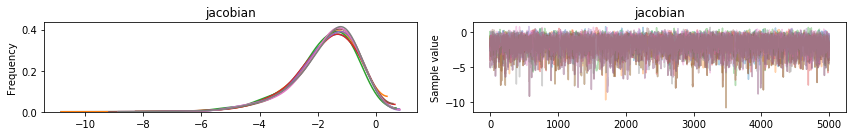

In [20]:
pm.traceplot(trtest, varnames=['jacobian']);

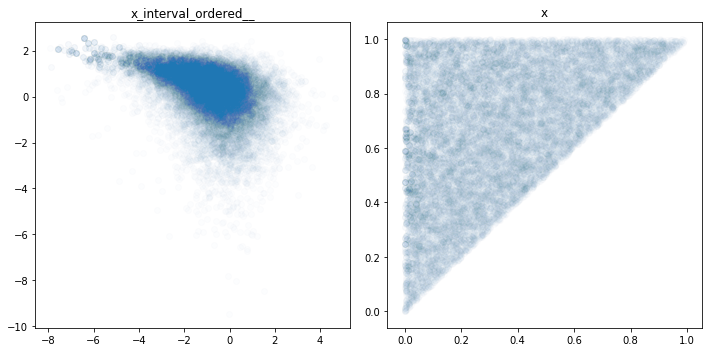

In [21]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
for ivar, varname in enumerate(varnames[:2]):
    ax[ivar].scatter(trtest[varname][:, 0], trtest[varname][:, 1], alpha=.01)
    ax[ivar].set_title(varname)
plt.tight_layout();

The Jacobian computed by hand seems to be correct, now try to pin down where went wrong when chaining the transformation together

In [22]:
x = np.asarray([2., 1.])
det = Order.jacobian_det(x) + Interval.jacobian_det(Order.backward(x))
det.eval()

array([-1.25385602, -3.73606357])

In [23]:
chain_tran.jacobian_det(x).eval()

array([-1.25385602, -3.73606357])

In [24]:
# testpoint = m2.test_point
testpoint = mtest.test_point
testpoint

{'x_interval_ordered__': array([2., 1.])}

In [25]:
m2.logp(testpoint)

array(-4.98991959)

In [26]:
mtest.logp(testpoint)

array(-5.98991959)

The model logp is different

In [27]:
factors = [var.logpt for var in m2.basic_RVs] + m2.potentials
func1 = theano.function(m2.basic_RVs, factors)
func1(np.asarray([2., 1.]))

[array(-4.98991959)]

In [28]:
factors = [var.logpt for var in mtest.basic_RVs] + mtest.potentials
func2 = theano.function(mtest.basic_RVs, factors)
func2(np.asarray([2., 1.]))

[array(0.), array(1.), array([0., 0.]), array([-2.25385602, -4.73606357])]

In [29]:
np.sum([np.sum(out) for out in func2(np.asarray([2., 1.]))])

-5.989919587258829

In [30]:
x0 = m2.basic_RVs[0]
x0.distribution.logp(x).eval()

array([-1.25385602, -3.73606357])

In [31]:
logp = m2.logp
lnp = np.array([logp(tr2.point(i,chain=c)) for c in tr2.chains for i in range(len(tr2))])

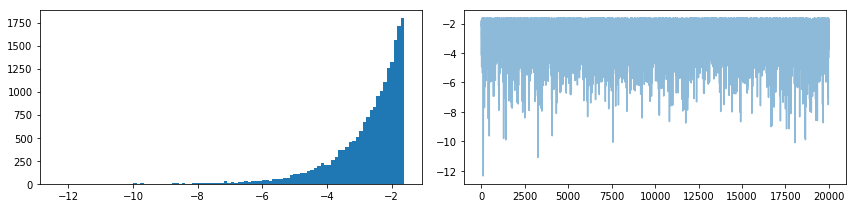

In [32]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(lnp, 100)
ax[1].plot(lnp, alpha=.5);
plt.tight_layout();

In [33]:
logp = mtest.logp
lnp = np.array([logp(trtest.point(i,chain=c)) for c in trtest.chains for i in range(len(trtest))])

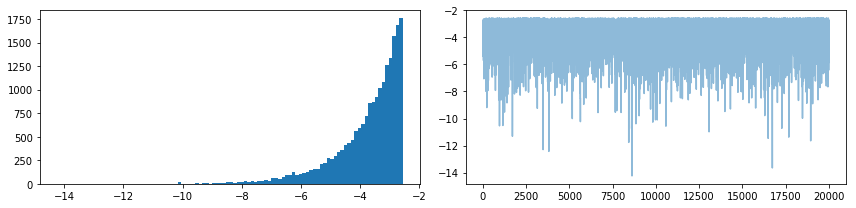

In [34]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(lnp, 100)
ax[1].plot(lnp, alpha=.5);
plt.tight_layout();

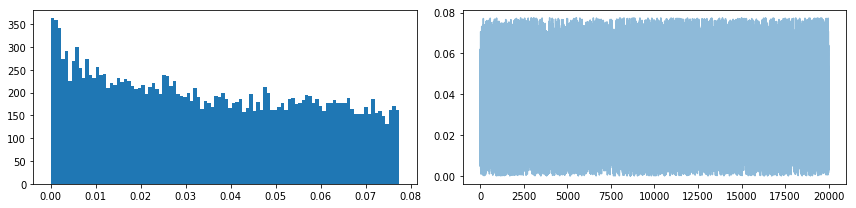

In [35]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(np.exp(lnp), 100)
ax[1].plot(np.exp(lnp), alpha=.5);
plt.tight_layout();

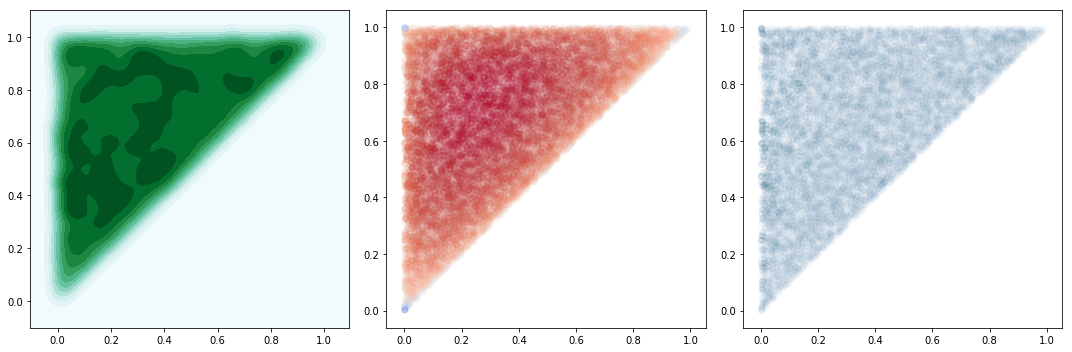

In [36]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))

varname = 'x'
sns.kdeplot(trtest[varname][:, 0], trtest[varname][:, 1], shade=True, ax=ax[0])
ax[1].scatter(trtest[varname][:, 0], trtest[varname][:, 1], c=lnp, cmap=plt.cm.coolwarm,
           alpha=.05)
ax[2].scatter(trtest[varname][:, 0], trtest[varname][:, 1], cmap=plt.cm.coolwarm,
           alpha=.01)
plt.tight_layout();

https://discourse.pymc.io/t/order-statistics-in-pymc3/617/3

[4 0 3 2 1]
[[3 1 1 3 1 4 4 1 1 1 1 1 1 1 4 4 1 1 1 1 1 1 1 1 4 1 1 1 1 1]
 [1 4 4 4 4 3 1 4 3 3 4 4 4 4 1 1 4 4 4 4 3 4 4 4 1 4 3 3 4 4]
 [4 3 3 2 2 1 3 2 4 4 3 0 2 3 2 3 2 3 3 3 4 3 2 3 3 3 4 0 2 0]
 [0 2 2 1 0 2 2 3 2 2 2 3 3 0 3 2 3 2 2 0 2 2 3 2 2 2 2 4 3 2]
 [2 0 0 0 3 0 0 0 0 0 0 2 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 3]]


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [latent_ordered2d__, mu_hat]
INFO:pymc3:NUTS: [latent_ordered2d__, mu_hat]
100%|██████████| 1000/1000 [00:06<00:00, 154.30it/s]


The true ranking is: 
[4 0 3 2 1]
The Latent mean is: 
[ 0.    2.84  1.93  0.47 -3.12]
The estimated ranking is: 
[4 0 3 2 1]


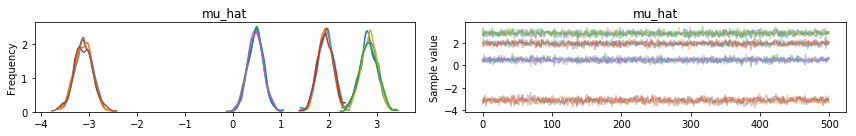

In [37]:
# data
K = 5 # number of items being ranked
J = 100 # number of raters
yreal = np.argsort(np.random.randn(K, 1), axis=0)
print(yreal.squeeze())
y = np.argsort(yreal + np.random.randn(K, J), axis=0)
print(y[:, :30])

class Ordered2D(pm.distributions.transforms.Transform):
    name = "ordered2d"

    def forward(self, x):
        out = tt.zeros(x.shape)
        out = tt.inc_subtensor(out[0,:], x[0,:])
        out = tt.inc_subtensor(out[1:,:], tt.log(x[1:,:] - x[:-1,:]))
        return out
    
    def forward_val(self, x, point=None):
        x, = pm.distributions.distribution.draw_values([x], point=point)
        return self.forward(x)

    def backward(self, y):
        out = tt.zeros(y.shape)
        out = tt.inc_subtensor(out[0,:], y[0,:])
        out = tt.inc_subtensor(out[1:,:], tt.exp(y[1:,:]))
        return tt.cumsum(out, axis=0)
    
    def jacobian_det(self, y):
        return tt.sum(y[1:,:], axis=0)

# transformed data{
y_argsort = np.argsort(y, axis=0)

with pm.Model():
    mu_hat = pm.Normal('mu_hat', 0, 1, shape=K-1)
    # set first value to 0 to avoid unidentified model
    mu = tt.concatenate([[0.], mu_hat])
    #sd = pm.HalfCauchy('sigma', 1.)
    latent = pm.Normal('latent',
                       mu=mu[y_argsort],
                       sd=1., # using sd does not work yet
                       transform=Ordered2D(), 
                       shape=(K,J),
                       testval=np.repeat(np.arange(K)[:,None], J, axis=1))
                        # There are some problems with Ordered 
                        # right now, you need to give a testval
    trace = pm.sample()
pm.traceplot(trace, varnames=['mu_hat']);

print('The true ranking is: ')
print(yreal.flatten())
print('The Latent mean is: ')
latentmu = np.hstack(([0], pm.summary(trace, varnames=['mu_hat'])['mean'].values))
print(np.round(latentmu,2))
print('The estimated ranking is: ')
print(np.argsort(latentmu))